In [601]:
# import libraries
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [602]:
# alpaca
try:
    import alpaca
except ImportError:
    !python3 -m pip install alpaca-py
    import alpaca

from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame

In [603]:
# alpaca api credentials
API_KEY = None
API_SECRET = None

if API_KEY is None:
    API_KEY = os.environ.get('API_KEY')

if API_SECRET is None:
    API_SECRET = os.environ.get('API_SECRET')

SYMBOL = "DXCM"
START_DATE = "2010-01-01"
END_DATE = None

client = StockHistoricalDataClient(API_KEY, API_SECRET)

In [604]:
# request historical data
request = StockBarsRequest(
    symbol_or_symbols=SYMBOL,
    timeframe=TimeFrame.Day,
    start=START_DATE,
)

bars = client.get_stock_bars(request)
df = bars.df.reset_index()

print("Last available bar:", df["timestamp"].max())

Last available bar: 2026-02-13 05:00:00+00:00


In [605]:
# set up features
df = df[df["symbol"] == SYMBOL]

# print(df.head())

# x features
df["return"] = df["close"].pct_change()
df["volatility"] = df["close"].rolling(window=5).std()

# moving averages
df["ma_5"] = df["close"].rolling(window=5).mean()
df["ma_10"] = df["close"].rolling(window=10).mean()
df["ma_20"] = df["close"].rolling(window=20).mean()
df["ma_50"] = df["close"].rolling(window=50).mean()
df["ma_100"] = df["close"].rolling(window=100).mean()

# y target
df["target"] = df["close"].shift(-1)
df = df.dropna()

features = [
    "close",
    "return",
    "volatility",
    "ma_5",
    "ma_10",
    "ma_20",
    "ma_50",
    "ma_100"
]

In [606]:
# split data
X = df[features]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    shuffle=False
)

In [607]:
# model
model = RandomForestRegressor(
    n_estimators=500,
    max_features='log2',
    max_depth=10,
    random_state=64
)

model.fit(X_train, y_train)

baseline_preds = X_test["close"].values
baseline_mae = mean_absolute_error(y_test.values, baseline_preds)
print(f"Baseline MAE: ${baseline_mae:.2f}")

test_preds = model.predict(X_test)
train_preds = model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)

print(f"Train MAE: ${train_mae:.2f}")
print(f"Test MAE: ${test_mae:.2f}")

Baseline MAE: $1.53
Train MAE: $2.35
Test MAE: $1.87


In [608]:
# predict for next closing price
model.fit(X.values, y)

# use iloc to get the last row by position
latest_features = X.iloc[-1].values.reshape(1, -1)
predicted_next_price = model.predict(latest_features)[0]

latest_close = df["close"].iloc[-1]

# model predicts next price directly
predicted_price = predicted_next_price
predicted_return = (predicted_price / latest_close) - 1

print(f"Latest Close: ${latest_close:.2f}")
print(f"Predicted Next Close: ${predicted_price:.2f}")
print(f"Predicted Return: {predicted_return:.2%}")

Latest Close: $65.08
Predicted Next Close: $67.36
Predicted Return: 3.50%


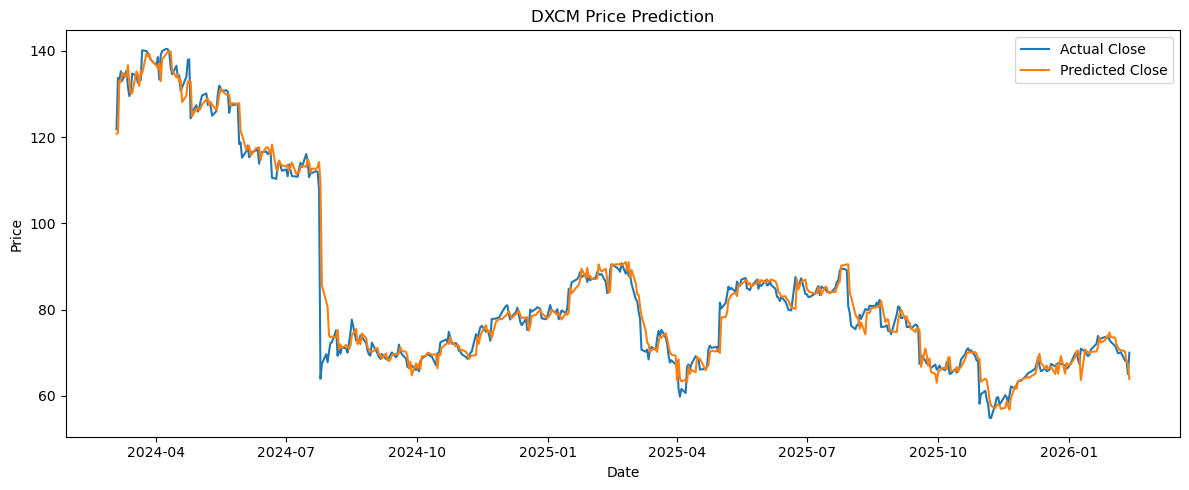

In [609]:
# prediction graph
test_dates = df.loc[X_test.index, "timestamp"]

plt.figure(figsize=(12,5))
plt.plot(test_dates, y_test.values, label="Actual Close")
plt.plot(test_dates, test_preds, label="Predicted Close")
plt.title(f"{SYMBOL} Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

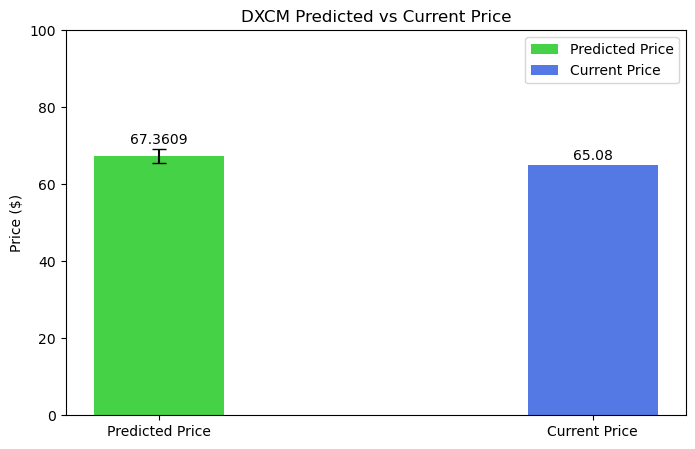

In [610]:
# predicted vs current price
difference = predicted_price - latest_close
abs_difference = abs(difference)

labels = ["Predicted Price", "Current Price"]
values = [predicted_price, latest_close]

plt.figure(figsize=(8,5))
x = np.arange(len(labels))

# predicted price bar
pred_bar = plt.bar(
    0,
    predicted_price,
    width=0.30,
    alpha=0.90,
    yerr=test_mae,
    capsize=5,
    color="limegreen",
    label="Predicted Price"
)

# current price bar
curr_bar = plt.bar(
    1,
    latest_close,
    width=0.30,
    alpha=0.90,
    color="royalblue",
    label="Current Price"
)

plt.title(f"{SYMBOL} Predicted vs Current Price")
plt.ylabel("Price ($)")
plt.xticks(x, labels)
plt.ylim(0, 100)
plt.legend(labels)
plt.bar_label(pred_bar, padding=1)
plt.bar_label(curr_bar, padding=1)
plt.show()